# Spatial Transformer Networks (STN)

- Paper: [2015.06.05] Spatial Transformer Networks (STN)
- https://arxiv.org/abs/1506.02025

### [Package load]

In [1]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.2
pytorch version: 2.2.2
GPU 사용 가능 여부: False


### [Model: STN]

- Code: https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html
- 설명: https://jamiekang.github.io/2017/05/27/spatial-transformer-networks/

1. Localisation network은 input feature map U에 적용할 transform의 parameter matrix theta 추정

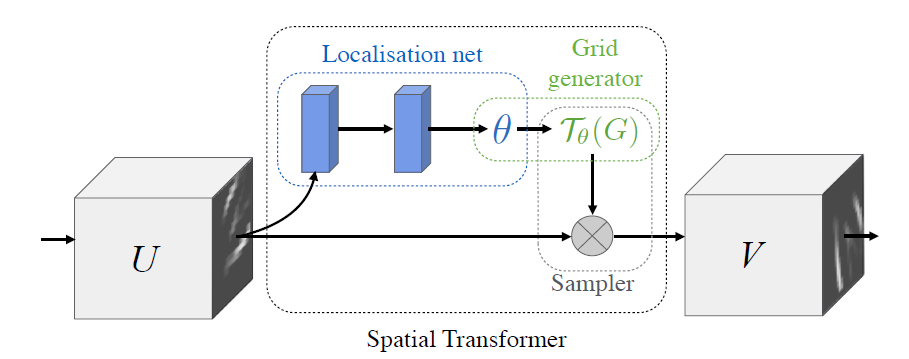

2. Grid generator는 추정한 theta에 따라 input feature map에서 sampling할 지점의 위치를 정해주는 sampling grid Tθ(G)를 계산
    - PyTorch에서는 affine_grid로 생성

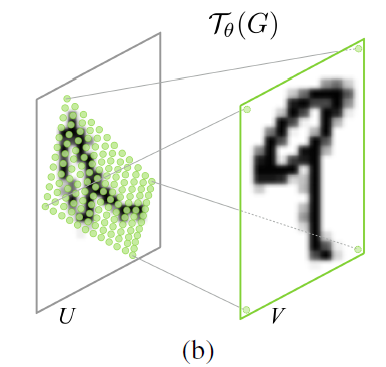

3. Sampler는 sampling grid Tθ(G)를 input feature map U에 적용해 변환된 output feature map V 생성
    - PyTorch에서는 grid_sample로 적용

In [11]:
class STN(nn.Module):
    def __init__(self):
        super(STN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix -> theta 값을 만들어내기
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias (항등 행렬로)
        self.fc_loc[2].weight.data.fill_(0)
        self.fc_loc[2].bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])

    def stn(self, x):
        x_stn = self.localization(x)            # localization 통과 -> output: (10, 3, 3)
        x_stn = x_stn.view(-1, 10 * 3 * 3)      # Theta 값 만들기 위해 행렬 조절
        theta = self.fc_loc(x_stn)              # Regressor 통과해서 Theta 만들기
        theta = theta.view(-1, 2, 3)            # theta를 2,3로 만들기

        grid = F.affine_grid(theta, x.size())   # (N, 2, 3)의 theta를 받아서 target output size인 x의 size만큼으로 출력 (Affine 시키는 것)
        x = F.grid_sample(x, grid)              # input과 grid가 주어졌을 때, grid의 입력 값과 픽셀 위치를 사용하여 최종 output을 계산
                                                # 참고: https://gaussian37.github.io/dl-pytorch-snippets/#fgrid_sample-%ED%95%A8%EC%88%98-%EC%82%AC%EC%9A%A9-%EC%98%88%EC%A0%9C-1
        return x    

    def forward(self, x):
        # 입력을 변환
        x = self.stn(x)

        # 일반적인 forward pass를 수행
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [12]:
stn = STN()

In [13]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 1, 28, 28))) # MNIST size
stn(temp).size()

c:\ProgramData\miniconda3\envs\for_learning\lib\site-packages\torch\nn\functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\ProgramData\miniconda3\envs\for_learning\lib\site-packages\torch\nn\functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([1, 10])

In [14]:
from torchsummary import summary
summary(stn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 22, 22]             400
         MaxPool2d-2            [-1, 8, 11, 11]               0
              ReLU-3            [-1, 8, 11, 11]               0
            Conv2d-4             [-1, 10, 7, 7]           2,010
         MaxPool2d-5             [-1, 10, 3, 3]               0
              ReLU-6             [-1, 10, 3, 3]               0
            Linear-7                   [-1, 32]           2,912
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 10, 24, 24]             260
           Conv2d-11             [-1, 20, 8, 8]           5,020
        Dropout2d-12             [-1, 20, 8, 8]               0
           Linear-13                   [-1, 50]          16,050
           Linear-14                   

In [15]:
from torchinfo import summary
summary(stn, input_size=(1, 1, 28, 28), col_width=20, depth=40, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)        Input Shape          Kernel Shape         Output Shape         Param %
STN (STN)                                [1, 1, 28, 28]       --                   [1, 10]                   --
├─Sequential (localization): 1-1         [1, 1, 28, 28]       --                   [1, 10, 3, 3]             --
│    └─Conv2d (0): 2-1                   [1, 1, 28, 28]       [7, 7]               [1, 8, 22, 22]         1.46%
│    └─MaxPool2d (1): 2-2                [1, 8, 22, 22]       2                    [1, 8, 11, 11]            --
│    └─ReLU (2): 2-3                     [1, 8, 11, 11]       --                   [1, 8, 11, 11]            --
│    └─Conv2d (3): 2-4                   [1, 8, 11, 11]       [5, 5]               [1, 10, 7, 7]          7.35%
│    └─MaxPool2d (4): 2-5                [1, 10, 7, 7]        2                    [1, 10, 3, 3]             --
│    └─ReLU (5): 2-6                     [1, 10, 3, 3]        --                   [1, 10, 3, 3]        